In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time

C:\Users\jan.zarnay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [347]:
# set the path for images
path = './Images'

In [319]:
def show_image(list_images):
    for i in list_images:
        cv2.imshow('image', i)
        cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
def hsv_resized(image):

    read_img = cv2.imread(image)
    width, height = read_img.shape[:2]

    width_resized = width // 2
    height_resized = height // 2
    
    res_image = cv2.resize(read_img, (height_resized, width_resized))
    hsv = cv2.cvtColor(res_image, cv2.COLOR_BGR2HSV)

    return hsv, res_image

In [5]:
def histogram(image):
    h_bins = 50  # hue
    s_bins = 60  # saturation
    histSize = [h_bins, s_bins, 256]

    h_ranges = [0,180]  # hue range 0 - 179
    s_ranges = [0,256]  # saturation range 0 - 255
    
    ranges = h_ranges + s_ranges + 256

    h, s, v = image[:,:,0], image[:,:,1], image[:,:,2]

    hist = cv2.calcHist([image], [0,1,2], None, histSize, ranges, accumulate = False)
    hist = cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    return hist.flatten(), h, s

In [320]:
## to be used for HSV color space

# image_1, image_col_1= hsv_resized(os.path.join(path, 'AirJordanFull.jpg'))

# image_2, image_col_2 = hsv_resized(os.path.join(path, 'AirJordanCut.jpg'))

In [328]:
# to be used for RGB color space

image_col_1= cv2.imread(os.path.join(path, 'AirJordanFull.jpg'))
image_1 = image_col_1

image_col_2 = cv2.imread(os.path.join(path, 'AirJordanCut.jpg'))
image_2 = image_col_2

In [329]:
show_image([image_1, image_2])

In [330]:
height, width, layers = image_col_1.shape

In [350]:
print(f'[INFO] Height: {height}, width: {width}, layers: {layers}')

[INFO] Height: 1140, width: 1600, layers: 3


In [332]:
columns = 15
rows = 15

# use "/" instead of "//" to being able correctly reshape the list for seaborn heatmap
# not important for histogram comparison
# if not column widht or height row not int, first higher column or row if true set up

width_column =  width / columns 
height_row = height / rows
n_segments = columns * rows

width_column, height_row, n_segments

print(f'[INFO] Columns: {columns}, width_column: {width_column}, rows: {rows}, height_row; {height_row} n_segments: {n_segments}', '\n')

if width % columns != 0:
    print(f'[INFO] Width_column has to be int number!')
    for i in range(1,100):
        columns = columns + 1
        if width % columns == 0:
            width_column = width / columns
            print(f'[INFO] New value for columns: {columns}, width_column: {width_column}')
            break
             
        
if height % rows != 0:
    print(f'\n[INFO] Height_row has to be int number!')
    for j in range(1,100):
        rows = rows + 1
        if height % rows == 0:
            height_row = height / rows
            print(f'[INFO] New value for rows: {rows}, height_row: {height_row}')
            break
            
n_segments = columns * rows

print(f'\n[INFO] Final dimensions:')
print(f'[INFO] Columns: {columns}, width_column: {width_column}, rows: {rows}, height_row; {height_row} n_segments: {n_segments}', '\n')

# set to int for further processing
width_column = int(width_column)
height_row = int(height_row)

[INFO] Columns: 15, width_column: 106.66666666666667, rows: 15, height_row; 76.0 n_segments: 225 

[INFO] Width_column has to be int number!
[INFO] New value for columns: 16, width_column: 100.0

[INFO] Final dimensions:
[INFO] Columns: 16, width_column: 100.0, rows: 15, height_row; 76.0 n_segments: 240 



In [216]:
### for H, S only in that color space, seems to be too sensitive

def hist_roi(image):
    
    segments = []
    histograms = []
        
    for i in range(0, height, height_row):
        for j in range(0, width, width_column):
            
            ROI = image[i:i + height_row, j:j + width_column]
            hist = cv2.calcHist([ROI], [0,1], None, [180,256], [0,180,0,256], accumulate = False)
            hist = cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            segments.append(ROI)
            hist = hist.flatten()
            histograms.append(hist)
        
    return segments, histograms

In [217]:
### for all 3 channels H, S, V in that color space, longer than H, S only

def hist_HSV(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    ROIs = []
    hists = []
    
    for i in range(0,height,height_row):
        for j in range(0,width,width_column):
            ROI = hsv[i:i+height_row, j:j+width_column]
            hist = cv2.calcHist([ROI], [0,1,2], None, [180, 256, 256] , [0,180,0,256,0,256], accumulate = None)
            hist = cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            
            ROIs.append(ROI)
            hists.append(hist)
            
    return ROIs, hists

In [218]:
# compare_method_names = {'0' : 'Correlation ', '1' : 'Chi_square  ', '2':'Intersection', '3':'Bhatacharyya'}

In [333]:
### for R, G, B in that color space, takes much time for real life situation

def hist_RGB(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ROIs = []
    hists = []
    
    for i in range(0,height,height_row):
        for j in range(0,width,width_column):
            ROI = hsv[i:i+width_column, j:j+height_row]
            # changed to 8 bins per color to decrease computing time
            hist = cv2.calcHist([ROI], [0,1,2], None, [8, 8, 8] , [0,256,0,256,0,256], accumulate = None)
            hist = cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            hist = hist.flatten()
            ROIs.append(ROI)
            hists.append(hist)
            
    return ROIs, hists

In [220]:
t = time.process_time()

seg_1, hist_1 = hist_roi(image_1)
seg_2, hist_2 = hist_roi(image_2)

elapsed_time = time.process_time() - t
print(f'[INFO] Process time: {elapsed_time} s')

[INFO] Process time: 0.15625 s


In [221]:
# seg_1, hist_1 = hist_HSV(image_1)
# seg_2, hist_2 = hist_HSV(image_2)

In [334]:
t = time.process_time()

seg_1, hist_1 = hist_RGB(image_col_1)
seg_2, hist_2 = hist_RGB(image_col_2)

elapsed_time = time.process_time() - t
print(f'[INFO] Process time: {elapsed_time} s')

[INFO] Process time: 0.03125 s


In [335]:
len(hist_1[0])

512

In [336]:
print(f'[INFO] Length of his_1: {len(hist_1)}')
print(f'[INFO] Length of his_2: {len(hist_2)}')
print(f'\n[INFO] Length of seg_1: {len(seg_1)}')
print(f'[INFO] Length of seg_2: {len(seg_2)}')    

[INFO] Length of his_1: 240
[INFO] Length of his_2: 240

[INFO] Length of seg_1: 240
[INFO] Length of seg_2: 240


In [337]:
# make matrix of segments + print number of segment into each cell + stack the images + write the image 

img1 = image_col_1.copy()
img2 = image_col_2.copy()

white = (255,255,255)
black = (0,0,0)
blue = (255,0,0)

def image_matrix (img):
    
    x = 0
    y = 0
    
    for i in range(0,height, height_row):
        cv2.line(img, (0,i), (width,i), black,1)

    for j in range(0,width, width_column):
        cv2.line(img, (j,0),(j, height), black,1)

### to check !!!! ###
    for i in range(0,height,height_row):
        for j in range(0,width,width_column):      
            cv2.putText(img, str(x), (j+(width_column//3),i+(height_row//3)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, black, 1)
            x = x + 1
            
##################            
                
    return img

def stack_images(img1, img2):
    im1 = image_matrix(img1)
    im2 = image_matrix(img2)
    combine = np.hstack((im1,im2))
    
    return combine

img_final = stack_images(img1, img2)

# for i in range(0,600,50):
#     cv2.putText(img, str(y), (20, i+35), cv2.FONT_HERSHEY_SIMPLEX, 0.5, black, 1)
#     y = y + 1 

cv2.imwrite(os.path.join(path,'Nike.jpg'), img_final)
print(f'[INFO] Image saved!')

[INFO] Image saved!


In [258]:
# compare_method_names = {'0' : 'Correlation ', '1' : 'Chi_square  ', '2':'Intersection', '3':'Bhatacharyya'}

In [338]:
chis = []

for hist1, hist2 in zip(hist_1, hist_2):
    chi_2 = cv2.compareHist(hist1, hist2, 1)
    chis.append(chi_2)

In [339]:
array = np.array(chis)

In [340]:
df = pd.DataFrame(chis)

In [341]:
df.describe()

,0
count,240.000000
mean,14.584539
std,207.560791
min,0.000000
25%,0.000000
50%,0.000000
75%,0.001570
max,3203.734022


In [263]:
# cv2.imshow('1', seg_1[30])
# cv2.imshow('2', seg_2[30])
# cv2.waitKey(0)

In [264]:
# cv2.destroyAllWindows()

(array([239.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   0.        ,  320.37340218,  640.74680436,  961.12020654,
        1281.49360873, 1601.86701091, 1922.24041309, 2242.61381527,
        2562.98721745, 2883.36061963, 3203.73402181]),
 <BarContainer object of 10 artists>)

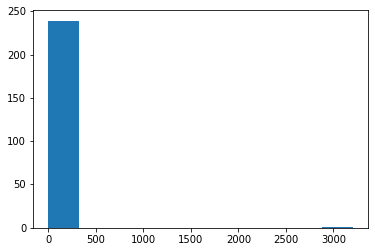

In [342]:
plt.hist(df)

In [343]:
array_reshaped = array.reshape( int(rows), int(columns))

In [344]:
cv2.compareHist(hist_1[93], hist_2[3], 2)

0.9999999403953552

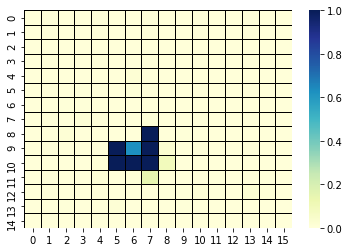

In [356]:
fig_1 = sns.heatmap(array_reshaped, vmin= 0.0, vmax=1, cmap="YlGnBu", annot=False, linewidths=1, linecolor='black' )

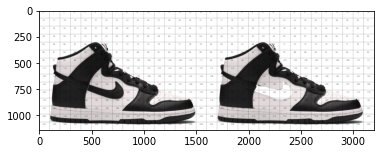

In [363]:
picture = cv2.imread('Nike.jpg')
plt.imshow(picture)

(1140, 3200, 3)

In [358]:
figure = fig_1.get_figure()
figure.savefig('fig_1.png', dpi=400)

In [346]:
cv2.compareHist(hist_1[165], hist_2[165], 1)

1.0537597478714684

In [277]:
# cv2.imshow('1', seg_1[30])
# cv2.imshow('2', seg_2[30])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [291]:
df.min()

0    0.194064
dtype: float64

In [310]:
len(array_reshaped[1])

16

In [312]:
len(df)

240